<a href="https://colab.research.google.com/github/gabri035/LeOpzioni/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Risultati Test ADF sulla serie originale:
ADF: -1.8559
p-value: 0.3531

Risultati Test ADF sulla serie differenziata:
ADF: -8.2332
p-value: 0.0000


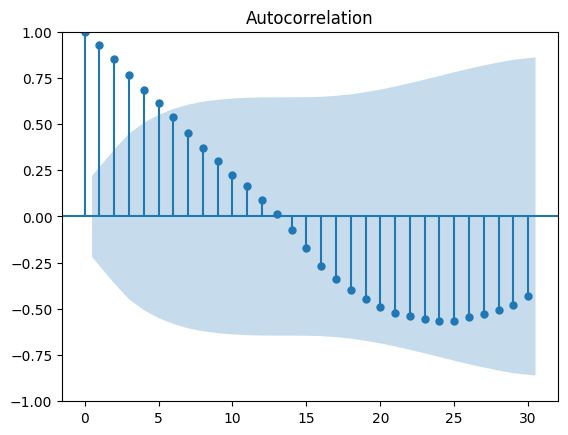

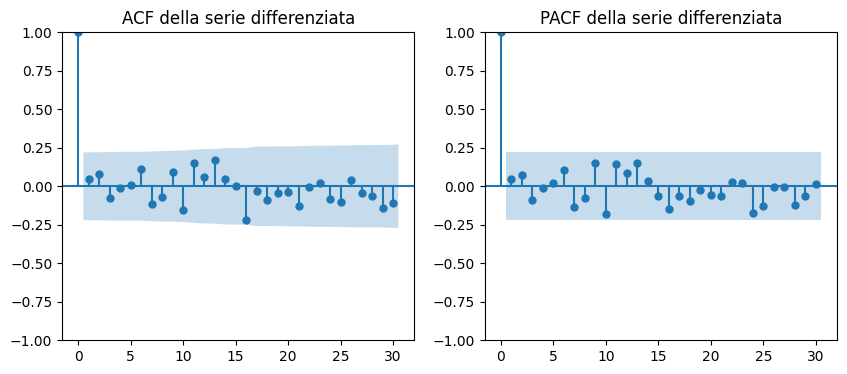

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                   80
Model:                 ARIMA(9, 1, 9)   Log Likelihood                -199.299
Date:                Sun, 02 Mar 2025   AIC                            436.599
Time:                        23:55:51   BIC                            481.618
Sample:                             0   HQIC                           454.635
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7399      3.418     -0.216      0.829      -7.438       5.959
ar.L2          0.3908      1.629      0.240      0.810      -2.802       3.584
ar.L3          0.4284      1.889      0.227      0.8

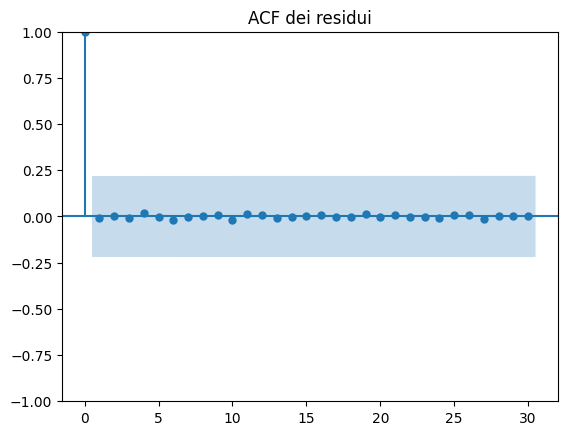

Risultati del Test Ljung-Box:
    lb_stat  lb_pvalue
10   0.1054        1.0


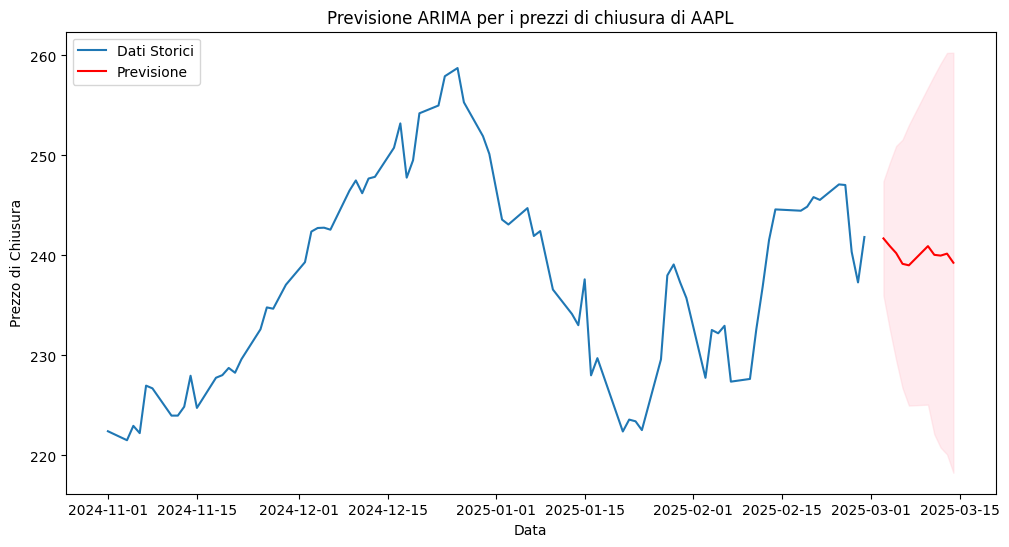

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")

start_date = '2024-11-1'
data = yf.download('AAPL', start=start_date, period="1d",)
close = data['Close'].dropna()
plot_acf(close, lags=30)


# Verifica di stazionarietà con il test di Dickey-Fuller
result = adfuller(close.dropna())

print('Risultati Test ADF sulla serie originale:')
print(f'ADF: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')


# Differenziazione
close_diff = close.diff().dropna()
result_diff = adfuller(close_diff)

print('\nRisultati Test ADF sulla serie differenziata:')
print(f'ADF: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')


# Plot di ACF e PACF per individuare possibili valori di p e q
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(close_diff, lags=30, ax=axes[0])
axes[0].set_title('ACF della serie differenziata')
plot_pacf(close_diff, lags=30, ax=axes[1])
axes[1].set_title('PACF della serie differenziata')
plt.show()


# Fit del modello ARIMA
order = (9, 1, 9)   # order = (p,d,q)
model = ARIMA(close, order=order)
model_fit = model.fit()

print(model_fit.summary())


# Plot dell'ACF dei residui
residuals = model_fit.resid
plot_acf(residuals, lags=30)
plt.title('ACF dei residui')
plt.show()

# Test Ljung-Box per verificare l'assenza di autocorrelazione nei residui
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Risultati del Test Ljung-Box:")
print(lb_test)

# ------------------------------------------------
# 6. Previsione con il modello ARIMA
# ------------------------------------------------
forecast_steps = 10  # Prevediamo i prossimi 30 giorni
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Creazione dell'indice temporale per le previsioni
forecast_index = pd.date_range(start=close.index[-1], periods=forecast_steps+1, freq='B')[1:]

# Plot della serie storica e della previsione
plt.figure(figsize=(12,6))
plt.plot(close, label='Dati Storici')
plt.plot(forecast_index, forecast_mean, label='Previsione', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Previsione ARIMA per i prezzi di chiusura di AAPL')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


Dimensione del dataset totale: 123
Dimensione del training set: 104
Dimensione del test set: 19

Risultati Test ADF sulla serie di training differenziata:
ADF Statistic: -9.8462
p-value: 0.0000


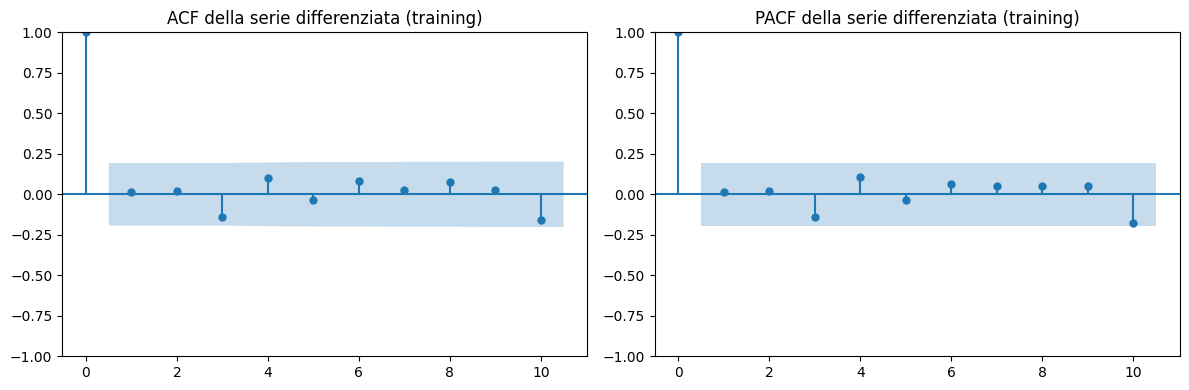


Sintesi del modello ARIMA adattato sui dati di training:
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  104
Model:                ARIMA(16, 1, 0)   Log Likelihood                -252.446
Date:                Sun, 02 Mar 2025   AIC                            538.893
Time:                        23:58:07   BIC                            583.683
Sample:                             0   HQIC                           557.035
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0376      0.129      0.292      0.770      -0.215       0.290
ar.L2          0.0698      0.111      0.632      0.528      -0.147       

<Figure size 800x400 with 0 Axes>

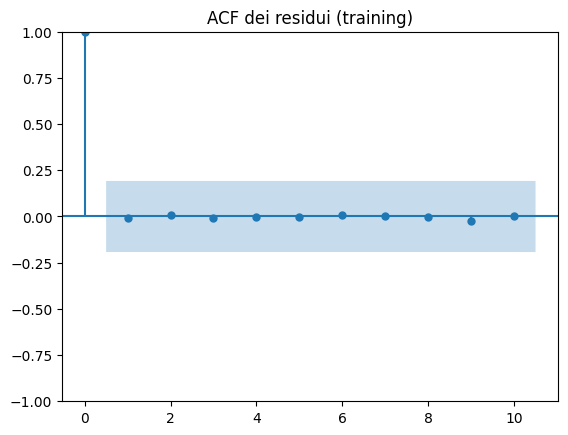

Risultati del Test Ljung-Box sui residui (training):
     lb_stat  lb_pvalue
10  0.119457        1.0


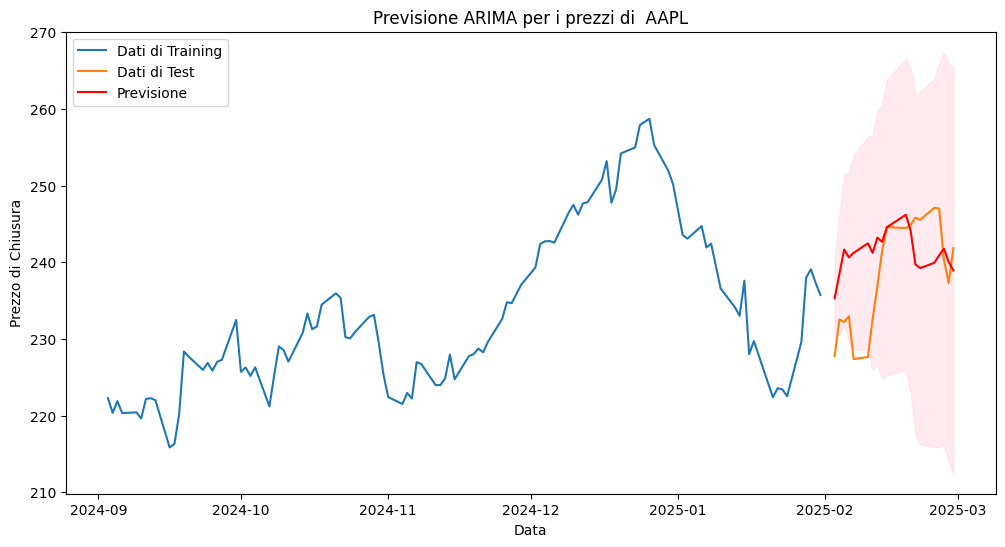

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")


# Scaricamento dei dati storici di AAPL
start_date = '2024-09-01'
data = yf.download('AAPL', start=start_date)
close = data['Close'].dropna()


# Divisione del dataset: 85% per il training, 15% per il test
split_index = int(len(close) * 0.85)
train = close.iloc[:split_index]
test  = close.iloc[split_index:]


# Visualizziamo le dimensioni dei dataset di training e test
print("Dimensione del dataset totale:", len(close))
print("Dimensione del training set:", len(train))
print("Dimensione del test set:", len(test))


# Differenziazione della serie di training
train_diff = train.diff().dropna()

# Test di stazionarietà (ADF) sulla serie differenziata di training
result_diff = adfuller(train_diff)
print('\nRisultati Test ADF sulla serie di training differenziata:')
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.4f}')

# Plot di ACF e PACF della serie differenziata di training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_diff, lags=10, ax=axes[0])
axes[0].set_title('ACF della serie differenziata (training)')
plot_pacf(train_diff, lags=10, ax=axes[1])
axes[1].set_title('PACF della serie differenziata (training)')
plt.tight_layout()
plt.show()


# Fit del modello ARIMA sui dati di training
order = (16,1,0)  # (p, d, q)
model = ARIMA(train, order=order)
model_fit = model.fit()

print("\nSintesi del modello ARIMA adattato sui dati di training:")
print(model_fit.summary())


plt.figure(figsize=(8,4))
plot_acf(residuals, lags=10)
plt.title('ACF dei residui (training)')
plt.show()

# Test Ljung-Box per verificare l'assenza di autocorrelazione nei residui
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Risultati del Test Ljung-Box sui residui (training):")
print(lb_test)

# Previsione: utilizziamo il modello ARIMA per prevedere il periodo di test
forecast_steps = len(test)  
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# L'indice per le previsioni corrisponde a quello del test set
forecast_index = test.index



# Plot dei dati: training, test e previsioni con intervalli di confidenza
plt.figure(figsize=(12,6))
plt.plot(train, label='Dati di Training')
plt.plot(test, label='Dati di Test')
plt.plot(forecast_index, forecast_mean, label='Previsione', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Previsione ARIMA per i prezzi di  AAPL')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.legend()
plt.show()
